In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
import statsmodels.stats.power as smp
from scipy.stats import norm,t, shapiro
from scipy import stats

In [2]:
def create_family_status(row):
    if row['marital.status'] == 'Married-civ-spouse':
        return 'Married-with-family' if row['relationship'] in ['Husband', 'Wife'] else 'Married-alone'
        
    if row['marital.status'] == 'Never-married':
        return 'Single-with-family' if row['relationship'] in ['Own-child', 'Other-relative'] else 'Single-alone'
        
    if row['marital.status'] == 'Divorced':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
        
    if row['marital.status'] == 'Widowed':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
        
    if row['marital.status'] == 'Separated':
        return 'Separated-with-family' if row['relationship'] != 'Not-in-family' else 'Separated-alone'
    
    return 'Not-in-Family'

def impute_mode(df, col_list):
    for col in col_list:
        df[col] = df[col].replace('?', np.nan)
        mode_value = df[col].mode()[0]
        df[col] = df[col].fillna(mode_value)



In [3]:
df_org = pd.read_csv(r"census_income_original_2.csv")
df = df_org.copy()

# preprocessiong
df = df_org.copy()

# encode income
df['income>50k'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# combine net gain and loss
df['capital.loss'] = df['capital.loss'] * -1
df['net_capital'] = df['capital.gain'] + df['capital.loss']
df['net_capital'] = df['net_capital'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))


# Clean
# Data inconsistency
df['income_value'] = pd.to_numeric(df['income_value'], errors='coerce')
df = df[~((df['occupation'] == 'Never worked') & (df['hours.per.week'] > 0))]
df = df[~((df['income>50k'] == 1) & (df['income_value'] <= 50000))]

# handlin income_value missing values (encode income value)
df['income_value_encoded'] = np.where(
    (df['income>50k'] == 1) & (df['income_value'] > 50000), 1,
        np.where((df['income>50k'] == 0) & (df['income_value'] <= 50000), 1, 0))



# handling missing catigorical variables
#impute_mode(df, ["occupation"])

#encode gender
mapping = {
    'm': 0,'m ': 0,'M': 0,'malee': 0,'male ': 0,'male': 0,'Male': 0,'Female': 1,'female': 1,'f': 1
}
df['Gender'] = df['Gender'].map(mapping)

# encode family 
df['family_status'] = df.apply(create_family_status, axis=1)

cat_cols = ['family_status', 'occupation']

# encode catigorical
encoder = ce.BinaryEncoder(cols=cat_cols)
df = encoder.fit_transform(df)

#df = pd.get_dummies(df, columns=cat_cols)

# rescale
quantile_transformer = QuantileTransformer(output_distribution='uniform', random_state=42)
#df[['age', 'hours.per.week']] = quantile_transformer.fit_transform(df[['age', 'hours.per.week']])

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[['age', 'hours.per.week']])
df[['age', 'hours.per.week']] = df_scaled

scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = scaler.fit_transform(df[['net_capital']])
df['net_capital'] = df_scaled



df.drop(columns=[ 'ID', 'capital.gain', 'capital.loss', 'education', 'race', 'native.country', 'workclass', 'income', 'income_value', 'marital.status', 'relationship'], inplace=True)


C:\Users\t-aelmiggabbar\AppData\Local\Temp\ipykernel_11460\2818722216.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_org = pd.read_csv(r"census_income_original_2.csv")


In [4]:
df.head(5)

,age,education.num,occupation_0,occupation_1,occupation_2,occupation_3,occupation_4,Gender,hours.per.week,income>50k,net_capital,income_value_encoded,family_status_0,family_status_1,family_status_2
0,1.000000,9,0,0,0,0,1,1,0.397959,0,-1.0,1,0,0,1
1,0.890411,9,0,0,0,1,0,1,0.173469,0,-1.0,1,0,0,1
2,0.671233,10,0,0,0,0,1,1,0.397959,0,-1.0,1,0,1,0
3,0.506849,4,0,0,0,1,1,1,0.397959,0,-1.0,1,0,1,0
4,0.328767,10,0,0,1,0,0,1,0.397959,0,-1.0,1,0,1,0


In [5]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve

In [6]:
X = df.drop(columns=['income>50k'])
y = df['income>50k']  


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Training set size (X_train):", X_train.shape)
print("Test set size (X_test):", X_test.shape)

Training set size (X_train): (26628, 14)
Test set size (X_test): (6657, 14)


In [7]:
def perform_grid_search(X_train, y_train, param_grid):
    grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)    
    print(f"Best parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    return best_model

param_grid = {
    'C': [0.01, 0.1, 1, 10],  
    'solver': ['liblinear', 'saga'],  
    'penalty': ['l1', 'elasticnet'], 
    'max_iter': [100, 150], 
}

#model = perform_grid_search(X_train, y_train, param_grid
# Best parameters: {'C': 0.1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'saga'}

In [8]:
def calculate_best_threshold(X_train, y_train):
    thresholds = np.linspace(0.3, 0.7, 16)
    model = LogisticRegression(C=0.1, max_iter=100, penalty='l1', solver='saga', random_state=42)
    best_threshold, max_precision, best_recall = 0.5, -1, 1

    for t in thresholds:
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_train)[:, 1]
        y_pred_thresholded = (y_pred_proba >= t).astype(int)
        
        TN, FP, FN, TP = confusion_matrix(y_train, y_pred_thresholded).ravel()
        precision, recall = TP / (TP + FP) if TP + FP else 0, TP / (TP + FN) if TP + FN else 0
        
        if precision < recall and precision > max_precision:
            max_precision, best_threshold, best_recall = precision, t, recall

    print(f"Maximum Precision where Precision < Recall: {max_precision}\nAt Threshold: {best_threshold}\nRecall: {best_recall}")
    return best_threshold
#calculate_best_threshold(X_train, y_train) #4.86

In [9]:
def CI_Eval(mean, var, n_folds, ci):
    std_dev = np.sqrt(var)
    z_score = t.ppf(1 - (1 - ci) / 2, n_folds-1) 
    margin_of_error = z_score * (std_dev / np.sqrt(n_folds))
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error
    print(f"{ci*100}% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

In [10]:

def bootstrap_ci(data, n_bootstraps=10000, ci_percentile=95):    
    bootstrap_means = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means[i] = np.mean(bootstrap_sample)
    
    lower_percentile = np.percentile(bootstrap_means, (100 - ci_percentile) / 2)
    upper_percentile = np.percentile(bootstrap_means, 100 - (100 - ci_percentile) / 2)
    
    return lower_percentile, upper_percentile

In [11]:
l = []

def CI_Eval(mean, var, n_folds, ci):
    # You can define your confidence interval logic here, for now just print CI
    z = 1.96  # For 95% confidence interval
    margin_of_error = z * np.sqrt(var / n_folds)
    ci_lower = mean - margin_of_error
    ci_upper = mean + margin_of_error
    print(f"Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

In [12]:
def train_evaluate_logreg(model, X, y, threshold=0.5):
    X = X.values if isinstance(X, pd.DataFrame) else X
    y = y.values if isinstance(y, pd.Series) else y
    
    cv = StratifiedKFold(n_splits=45, shuffle=True, random_state=42)
    f1_scores = []
    roc_auc_scores = []
    precision_scores = []
    recall_scores = []
    all_conf_matrices = []
    all_fpr = []  
    all_tpr = [] 
    all_thresholds = []  

    fold_idx = 1
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
        
        conf_matrix = confusion_matrix(y_val, y_pred_thresholded)        
        
        TN, FP, FN, TP = conf_matrix.ravel()        
        precision = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1 = f1_score(y_val, y_pred_thresholded)
        roc_auc = roc_auc_score(y_val, y_pred_proba)
        
        f1_scores.append(f1)
        precision_scores.append(precision)
        recall_scores.append(recall)
        roc_auc_scores.append(roc_auc)
        all_conf_matrices.append(conf_matrix)
        
        # Calculate ROC curve
        fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_thresholds.append(thresholds)
        
        print(f"Fold {fold_idx}:")
        print(f"Threshold: {threshold}")
        print(f"FN: {FN} | FP: {FP} | TP: {TP} | TN: {TN}")
        print(f"Precision: {precision:.4f} | Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f} | ROC AUC: {roc_auc:.4f}")
        print("-" * 50)
        
        l.append(f1)
        fold_idx += 1
        
    print("-" * 50)
    print(f"Mean F1 Score across all folds: {np.mean(f1_scores):.4f}")
    print(f"Variance F1 Score across all folds: {np.var(f1_scores):.4f}")
    print(f"Mean Precision across all folds: {np.mean(precision_scores):.4f}")
    print(f"Mean Recall across all folds: {np.mean(recall_scores):.4f}")
    print(f"Mean ROC AUC across all folds: {np.mean(roc_auc_scores):.4f}")
    print("-" * 50)
    
    mean = np.mean(f1_scores)
    var = np.var(f1_scores)
    n_folds = 45
    ci = 0.95
    CI_Eval(mean, var, n_folds, ci)
    lower_ci, upper_ci = bootstrap_ci(f1_scores, n_bootstraps=10000, ci_percentile=95)
    print(f"95% Confidence Interval for F1 Scores bootstrap: ({lower_ci:.4f}, {upper_ci:.4f})")
    #plot_ROC(all_fpr, all_tpr)



In [13]:
def plot_ROC(all_fpr, all_tpr):
    plt.figure(figsize=(8, 6))
    for i in range(len(all_fpr)):
        plt.plot(all_fpr[i], all_tpr[i], label=f'Fold {i+1}')
    
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve Across Folds')
    plt.legend(loc='lower right')
    plt.show()

In [14]:
model = LogisticRegression(C=0.1, max_iter=100, penalty='l1', solver='saga', random_state=42)

threshold = 0.48
train_evaluate_logreg(model, X_train, y_train, threshold=threshold)

Fold 1:
Threshold: 0.48
FN: 48 | FP: 45 | TP: 100 | TN: 399
Precision: 0.6897 | Recall: 0.6757
F1 Score: 0.6826 | ROC AUC: 0.9143
--------------------------------------------------
Fold 2:
Threshold: 0.48
FN: 38 | FP: 43 | TP: 110 | TN: 401
Precision: 0.7190 | Recall: 0.7432
F1 Score: 0.7309 | ROC AUC: 0.9348
--------------------------------------------------
Fold 3:
Threshold: 0.48
FN: 40 | FP: 31 | TP: 108 | TN: 413
Precision: 0.7770 | Recall: 0.7297
F1 Score: 0.7526 | ROC AUC: 0.9347
--------------------------------------------------
Fold 4:
Threshold: 0.48
FN: 41 | FP: 31 | TP: 107 | TN: 413
Precision: 0.7754 | Recall: 0.7230
F1 Score: 0.7483 | ROC AUC: 0.9457
--------------------------------------------------
Fold 5:
Threshold: 0.48
FN: 30 | FP: 37 | TP: 118 | TN: 407
Precision: 0.7613 | Recall: 0.7973
F1 Score: 0.7789 | ROC AUC: 0.9447
--------------------------------------------------
Fold 6:
Threshold: 0.48
FN: 36 | FP: 37 | TP: 112 | TN: 407
Precision: 0.7517 | Recall: 0.7568


Test Statistic: 0.9433
P-value: 0.0286
reject h0: not normal


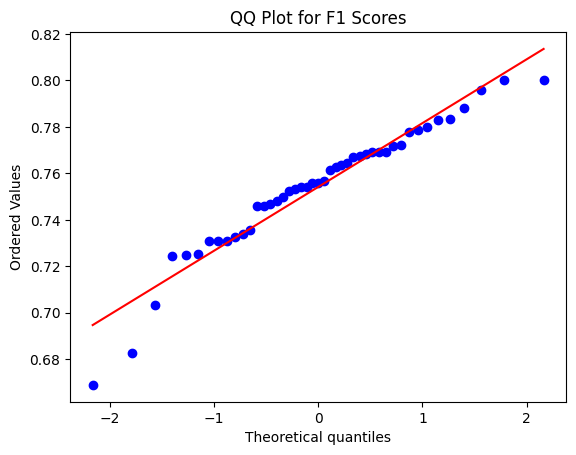

In [15]:
stat, p_value = shapiro(l)
print(f"Test Statistic: {stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("reject h0: not normal")
else:
    print("fail to reject h0: normal")


stats.probplot(l, dist="norm", plot=plt)
# Display the plot
plt.title("QQ Plot for F1 Scores")
plt.show()

In [16]:
mean_accuracy = 0.75 
variance = 0.0001  
n_folds = 5  

std_dev = np.sqrt(variance)
confidence_level = 0.95
z_score = norm.ppf(1 - (1 - confidence_level) / 2) 
margin_of_error = z_score * (std_dev / np.sqrt(n_folds))
lower_bound = mean_accuracy - margin_of_error
upper_bound = mean_accuracy + margin_of_error

print(f"95% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})")

95% Confidence Interval: (0.7412, 0.7588)


In [17]:
def test_model(model, X_test, y_test, threshold=0.5):
    # Ensure the features and target are in the right format (numpy arrays)
    X_test = X_test.values if isinstance(X_test, pd.DataFrame) else X_test
    y_test = y_test.values if isinstance(y_test, pd.Series) else y_test
        
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
    
    conf_matrix = confusion_matrix(y_test, y_pred_thresholded)
    TN, FP, FN, TP = conf_matrix.ravel()
    
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1 = f1_score(y_test, y_pred_thresholded)

    print(f"Test Set Evaluation:")
    print(f"Threshold: {threshold}")
    print(f"FN: {FN} | FP: {FP} | TP: {TP} | TN: {TN}")
    print(f"Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


In [18]:
threshold = 0.486
test_model(model, X_test, y_test, threshold)

Test Set Evaluation:
Threshold: 0.486
FN: 396 | FP: 437 | TP: 1270 | TN: 4554
Precision: 0.7440 | Recall: 0.7623
F1 Score: 0.7530


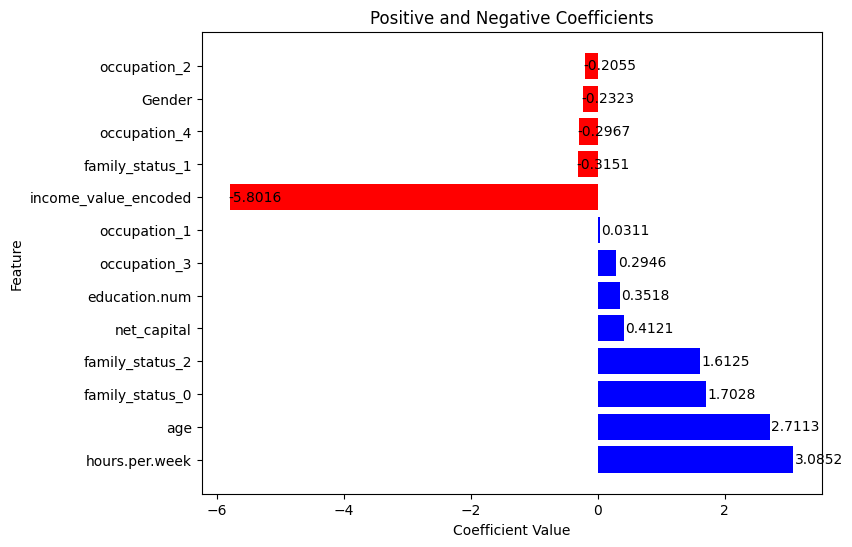

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get the coefficients
coeffs = model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coeffs})

max_abs_coeff = np.max(np.abs(coeffs))  
coef_df["Normalized Coefficient"] = coef_df["Coefficient"] #/ max_abs_coeff  
positive_coef_df = coef_df[coef_df["Normalized Coefficient"] > 0].sort_values(by="Normalized Coefficient", ascending=False).head(10)
negative_coef_df = coef_df[coef_df["Normalized Coefficient"] < 0].sort_values(by="Normalized Coefficient", ascending=True).head(10)
combined_coef_df = pd.concat([positive_coef_df, negative_coef_df])

plt.figure(figsize=(8, 6))
plt.barh(combined_coef_df["Feature"], combined_coef_df["Normalized Coefficient"], color=['blue' if x > 0 else 'red' for x in combined_coef_df["Normalized Coefficient"]])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Positive and Negative Coefficients')

for i, v in enumerate(combined_coef_df["Coefficient"]):
    plt.text(v + 0.02 if v > 0 else v - 0.02, i, f"{v:.4f}", va='center', color='black')

plt.show()


In [20]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm


hessian_inv = np.linalg.inv(np.dot(X_train.T, X_train))
feature_names = X.columns
def wald_test(model, feature_idx, X_train):
    coef = model.coef_[0][feature_idx]    
    se = np.sqrt(np.diagonal(hessian_inv)[feature_idx])    
    z_stat = coef / se
    p_value = 2 * (1 - norm.cdf(np.abs(z_stat)))
    
    return z_stat, p_value

for feature_idx in range(X_train.shape[1]):
    z_stat, p_value = wald_test(model, feature_idx, X_train)
    if p_value >= 0.05:
        print(f"no significance - Wald test statistic for {feature_names[feature_idx]}: {z_stat:.4f}")
        print(f"P-value: {p_value:.4f}\n")


no significance - Wald test statistic for occupation_0: 0.0000
P-value: 1.0000

